In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2023-04-16 15:13:57.405702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:13:57.500850: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 15:13:57.530426: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 15:13:58.307790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.getcwd()

'/home/cbasire/Data Mining'

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

start_path = '/home/cbasire/Data Mining/BSE_BET_DATA/'
image_file_paths = glob(start_path+'files/*')



## data pre process completed

In [4]:
with open('np_X_data.pickle', 'rb') as f:
    np_X_data = pickle.load(f)
with open('Y_feature.pickle', 'rb') as f:
    Y_feature = pickle.load(f)

In [5]:
with open('np_X_data_rotate.pickle', 'rb') as f:
    np_X_data_rotate = pickle.load(f)
with open('Y_feature_rotate.pickle', 'rb') as f:
    Y_feature_rotate = pickle.load(f)

In [6]:
np_X_data_train = np.concatenate((np_X_data,np_X_data_rotate),axis = 0)

In [7]:
np_X_data_train.shape

(4120, 128, 128, 64)

In [8]:
Y_feature_train = np.concatenate((Y_feature,Y_feature_rotate),axis = 0)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(np_X_data_train,Y_feature_train,test_size=0.3,random_state = 42)

In [10]:
X_train.shape

(2884, 128, 128, 64)

In [11]:
X_test.shape

(1236, 128, 128, 64)

### Model generation for brain_feature loss

In [12]:
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [13]:
# brainLoss dataloaders (manage memory usage)
train_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

2023-04-16 15:14:34.310817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:14:35.422864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78848 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2023-04-16 15:14:35.425208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78928 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [14]:
batch_size = 24

# Augment the on the fly during training.
train_dataset_brainLoss = (
    train_loader_brainLoss.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset_brainLoss = (
    test_loader_brainLoss.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [15]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""    
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnnfeature")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnnfeature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 8)   224       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 8)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 16)    3472      
                                                      

In [16]:
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_brainLoss.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [17]:
epochs = 30
model.fit(
    train_dataset_brainLoss,
    validation_data=test_dataset_brainLoss,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/30


2023-04-16 15:14:53.324364: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-16 15:14:55.070216: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


121/121 [==============================] - 301s 2s/step - loss: 0.6456 - acc: 0.7268 - val_loss: 0.7065 - val_acc: 0.3600
Epoch 2/30
121/121 [==============================] - 299s 2s/step - loss: 0.5494 - acc: 0.9286 - val_loss: 0.6172 - val_acc: 0.8617
Epoch 3/30
121/121 [==============================] - 299s 2s/step - loss: 0.4791 - acc: 0.9397 - val_loss: 0.4886 - val_acc: 0.8107
Epoch 4/30
121/121 [==============================] - 299s 2s/step - loss: 0.4267 - acc: 0.9431 - val_loss: 0.3606 - val_acc: 0.9684
Epoch 5/30
121/121 [==============================] - 297s 2s/step - loss: 0.3878 - acc: 0.9424 - val_loss: 0.3040 - val_acc: 0.9757
Epoch 6/30
121/121 [==============================] - 297s 2s/step - loss: 0.3608 - acc: 0.9359 - val_loss: 0.2823 - val_acc: 0.9814
Epoch 7/30
121/121 [==============================] - 298s 2s/step - loss: 0.3420 - acc: 0.9376 - val_loss: 0.2665 - val_acc: 0.9806
Epoch 8/30
121/121 [==============================] - 299s 2s/step - loss: 0.323

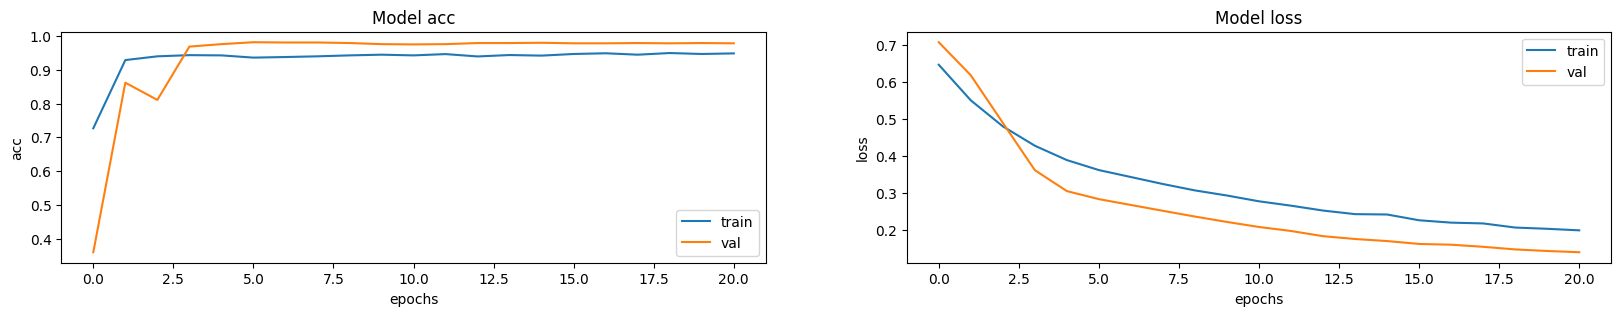

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
# Load saved model & weights
model = keras.models.load_model('3d_brainLoss.h5')
model.load_weights("3d_brainLoss.h5")

In [21]:
model.predict(np.expand_dims(X_test[10], axis=0))[0]

1/1 [==============================] - 0s 126ms/step


array([0.827277], dtype=float32)

In [ ]:
Y_test[10]